In [1]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [2]:
threshold_event_magnitude = 0.5

In [3]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

509 Event(s) in Catalog:
2010-05-27T16:25:25.312700Z | +48.048,  +11.644 | 0.0839474806054 Ml
2010-01-31T08:00:57.025500Z | +48.048,  +11.643 | 0.039033276658 Ml
...
2019-01-18T21:53:12.483393Z | +48.049,  +11.646 | -0.472072504528 None
2019-12-31T17:47:30.953434Z | +48.045,  +11.644 | -0.497145528261 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [5]:
def plot_model_evolution(Loss,b,c,U,V,W):
    fig,ax = plt.subplots(nrows=6,figsize=(15,15),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(V[:,0,0],label='V11')
    ax[3].plot(V[:,0,1],label='V12')
    ax[3].plot(V[:,0,2],label='V13')
    ax[3].plot(V[:,1,0],label='V21')
    ax[3].plot(V[:,1,1],label='V22')
    ax[3].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[4].plot(U[:,i,j],label=ulabels[i][j])
            ax[5].plot(W[:,i,j],label=wlabels[i][j])
            
    for i in range(6):
        ax[i].legend(fontsize=8)
    plt.show() 

In [6]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [7]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [8]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [149]:
def initialization(Nit,Wpast,save=False,savename='_'):

    U = np.zeros((Nit,3,3))
    W = np.zeros((Nit,3,3,Wpast))
    b = np.zeros((Nit,3))
    V = np.zeros((Nit,2,3))
    c = np.zeros((Nit,2))

    dU = np.zeros((Nit,3,3))
    dW = np.zeros((Nit,3,3,Wpast))
    db = np.zeros((Nit,3))
    dV = np.zeros((Nit,2,3))
    dc = np.zeros((Nit,2))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000
    if not save:
        for i in range(3):
            for j in range(3):
                U[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
                for k in range(Wpast):
                    W[0,i,j,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom  
            b[0,i]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom   
        for i in range(2):
            for k in range(3):
                V[0,i,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
            c[0,i] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
    else:
        b[0], c[0], U[0], V[0], W[0] = loadmodel(savename,Wpast)
        
    Loss = np.zeros(Nit)

    return U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss

In [86]:
def prediction(b,c,U,V,W,x,Wpast):
    N = len(x)
    a = np.zeros((N,3))
    h = np.zeros((N,3))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0] = b + np.dot(U,x[0])
    h[0] = np.tanh(a[0])
    o[0] = c + np.dot(V,h[0])
    yhat[0] = softmax(o[0,:])
    for t in range(1,Wpast):
        hidden = np.zeros(3)
        for j in range(t):
            hidden += np.dot(W[:,:,t-(j+1)],h[j])
        a[t] = b + np.dot(U,x[t]) + hidden
        h[t] = np.tanh(a[t])
        o[t] = c + np.dot(V,h[t])
        yhat[t] = softmax(o[t,:])
    for t in range(Wpast,N):
        hidden = np.zeros(3)
        for j in range(Wpast):
            hidden += np.dot(W[:,:,Wpast-(j+1)],h[t-Wpast+j])
        a[t] = b + np.dot(U,x[t]) + hidden
        h[t] = np.tanh(a[t])
        o[t] = c + np.dot(V,h[t])
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(h,o,V,W,x,y,yhat):
    N = len(x)
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,3))
    dh[-1] = np.dot(V.transpose(),do[-1])
    
    for t in range(N-2,N-np.shape(W)[2]-2,-1):
        hidden = np.zeros(3)
        for k in range(N-t-1):
            diag = np.diag(np.array([1-h[t+k+1,0]**2,1-h[t+k+1,1]**2,1-h[t+k+1,2]**2]))
            hidden += np.dot(np.dot(W[:,:,k].transpose(),diag),dh[t+k+1])
        dh[t] = hidden + np.dot(V.transpose(),do[t])
    
    
    for t in range(N-np.shape(W)[2]-2,-1,-1):
        hidden = np.zeros(3)
        for k in range(np.shape(W)[2]):
            diag = np.diag(np.array([1-h[t+k+1,0]**2,1-h[t+k+1,1]**2,1-h[t+k+1,2]**2]))
            hidden += np.dot(np.dot(W[:,:,k].transpose(),diag),dh[t+k+1])
        dh[t] = hidden + np.dot(V.transpose(),do[t])

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros(3)
    dV = np.zeros((2,3))
    dW = np.zeros((3,3,np.shape(W)[2]))
    dU = np.zeros((3,3))
    for i in range(3):
        for t in range(N):
            db[i] += (1-h[t,i]**2)*dh[t,i]
    
    for t in range(N):
        dV[0,0] += do[t,0]*h[t,0]
        dV[1,0] += do[t,1]*h[t,0]
        dV[0,1] += do[t,0]*h[t,1]
        dV[1,1] += do[t,1]*h[t,1]
        dV[0,2] += do[t,0]*h[t,2]
        dV[1,2] += do[t,1]*h[t,2]
    
    for k in range(np.shape(W)[2]):
        for t in range(1,N):
            mat = np.zeros((3,3))
            for i in range(3):
                for j in range(3):
                    mat[i,j] = dh[t,i] * h[t-(k+1),j]
            dW[:,:,k] += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat)

    for t in range(1,N):
        mat2 = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                mat2[i,j] = dh[t,i] * x[t,j]
        dU += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat2)
    return db,dc,do,dU,dV,dW

In [11]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [134]:
#data acquisition
N = len(data)
x = [[],[],[]]
y = [[],[]]
index = 0
for i in range(N):
    if not np.isnan(data['Flowrate'][i]):
        x[0].append(data['Flowrate'][i])
        x[1].append(data['Temperature'][i])
        x[2].append(data['Pressure'][i])
        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()
x = mapx(x)
N = len(x)

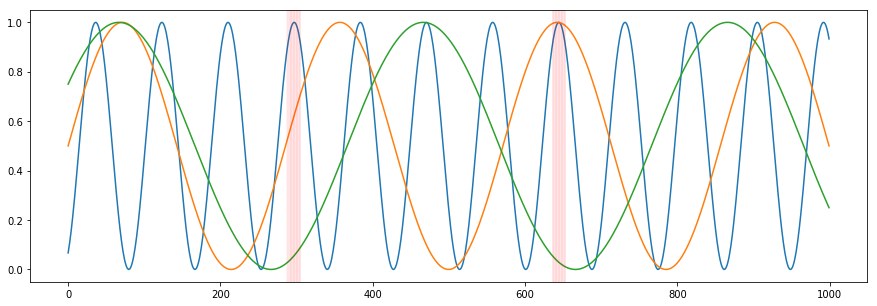

In [129]:
#fake data
N = 1000
x = np.zeros((N,3))
y = np.zeros((N,2))
x[:,0] = (np.sin(np.linspace(0,23*np.pi,N)-np.pi/3)+1)/2
x[:,1] = (np.sin(np.linspace(0,7*np.pi,N))+1)/2
x[:,2] = (np.sin(np.linspace(0,5*np.pi,N)+np.pi/6)+1)/2
plt.figure(figsize=(15,5))
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])
xx = []
yy = []
for i in range(N):
    if x[i,0]>0.9 and x[i,2]<0.1:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,0]))
        plt.axvline(i,lw=0.1,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()
x = mapx(x)

### RNN-model, fig. 10.4. Hidden nodes influence following hidden nodes

Model estimations seem great! A lot of potential!

In [150]:
Nit = 1000
eps = 0.0001
Wpast = 2
save = True
savename = 'firstrun'

U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss = initialization(Nit,Wpast,save=save,savename=savename)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],U[k],V[k],W[k],x,Wpast)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],do,dU[k],dV[k],dW[k] = gradients(h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]

    

0 923.195249141
1 919.507751079
2 916.970792499
3 915.246534601
4 914.085381062
5 913.308444499
6 912.790488868
7 912.445416256
8 912.214865527
9 912.059711865
10 911.95395443
11 911.880433968
12 911.827889512
13 911.788964488
14 911.758870902
15 911.734502127
16 911.713847657
17 911.69560917
18 911.678949768
19 911.663330803
20 911.648406005
21 911.63395298
22 911.61982897
23 911.605942344
24 911.592234254
25 911.578666846
26 911.565215697
27 911.551864972
28 911.538604319
29 911.525426881
30 911.512328037
31 911.499304588
32 911.486354241
33 911.473475282
34 911.460666371
35 911.447926402
36 911.435254424
37 911.422649586
38 911.410111105
39 911.397638241
40 911.385230285
41 911.372886554
42 911.360606379
43 911.348389107
44 911.336234097
45 911.324140718
46 911.312108349
47 911.300136378
48 911.288224201
49 911.276371223
50 911.264576856
51 911.252840523
52 911.24116165
53 911.229539675
54 911.217974041
55 911.206464199
56 911.195009608
57 911.183609733
58 911.172264047
59 911.16097

464 908.414057028
465 908.407481328
466 908.400871876
467 908.394228086
468 908.387549366
469 908.380835121
470 908.374084749
471 908.367297647
472 908.360473204
473 908.353610809
474 908.346709846
475 908.339769693
476 908.332789729
477 908.325769325
478 908.318707854
479 908.311604682
480 908.304459175
481 908.297270697
482 908.290038608
483 908.282762268
484 908.275441036
485 908.268074268
486 908.260661321
487 908.253201551
488 908.245694313
489 908.238138963
490 908.230534858
491 908.222881356
492 908.215177815
493 908.207423594
494 908.199618058
495 908.19176057
496 908.183850498
497 908.175887212
498 908.167870088
499 908.159798504
500 908.151671843
501 908.143489493
502 908.135250846
503 908.126955303
504 908.118602268
505 908.110191153
506 908.101721377
507 908.093192366
508 908.084603554
509 908.075954383
510 908.067244305
511 908.05847278
512 908.049639276
513 908.040743274
514 908.031784263
515 908.022761742
516 908.013675223
517 908.004524227
518 907.995308286
519 907.9860

922 905.135853781
923 905.134717234
924 905.133582512
925 905.132449605
926 905.131318503
927 905.130189194
928 905.129061667
929 905.127935914
930 905.126811922
931 905.125689683
932 905.124569185
933 905.123450419
934 905.122333375
935 905.121218042
936 905.12010441
937 905.11899247
938 905.117882212
939 905.116773626
940 905.115666703
941 905.114561432
942 905.113457805
943 905.112355811
944 905.111255442
945 905.110156688
946 905.109059539
947 905.107963987
948 905.106870022
949 905.105777636
950 905.104686818
951 905.103597561
952 905.102509855
953 905.101423691
954 905.100339061
955 905.099255955
956 905.098174366
957 905.097094284
958 905.096015701
959 905.094938608
960 905.093862997
961 905.09278886
962 905.091716187
963 905.090644972
964 905.089575205
965 905.088506879
966 905.087439984
967 905.086374515
968 905.085310461
969 905.084247815
970 905.08318657
971 905.082126717
972 905.081068249
973 905.080011158
974 905.078955436
975 905.077901075
976 905.076848068
977 905.075796

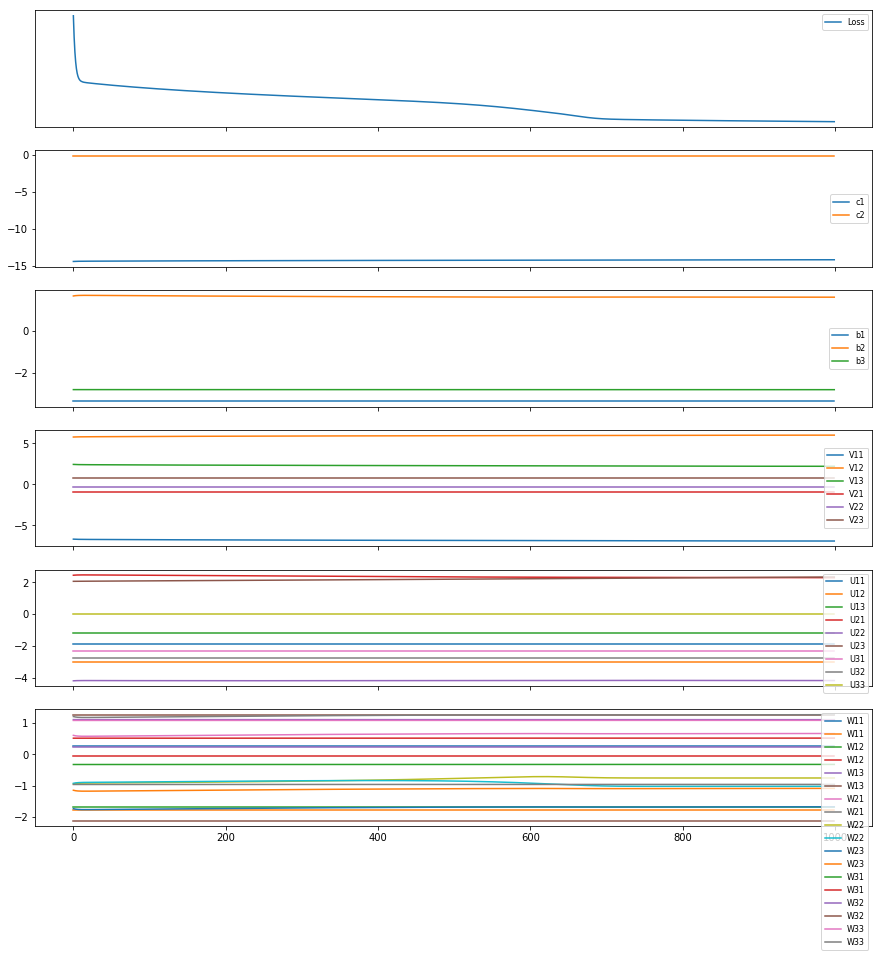

In [151]:
plot_model_evolution(Loss,b,c,U,V,W)

In [152]:
_,_,pred = prediction(b[-1],c[-1],U[-1],V[-1],W[-1],x,Wpast)

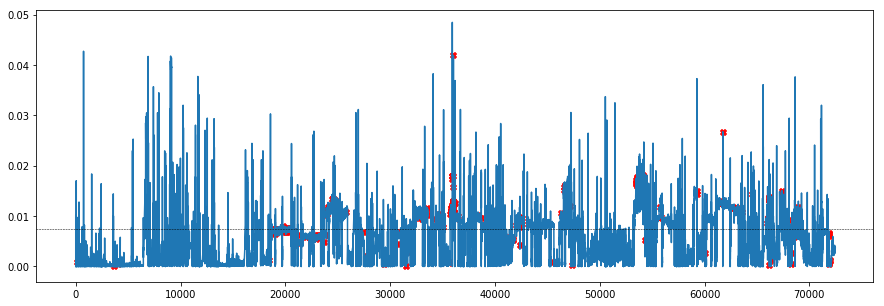

True Positives:   236
False Positives:  19363
False Negatives:  121
True Negatives:   52753


In [156]:
q = 0.0075

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
#plt.savefig('RNN_Wexp_finalLoss_905')
plt.show()

C = Confusionmatrix(y,pred,q)

In [155]:
savemodel('secondrun',b[-1],c[-1],U[-1],V[-1],W[-1])

In [146]:
def savemodel(savename,b,c,U,V,W):
    specification = 'RNN_Models/RNN_Wexp_'+savename+'_'
    np.savetxt(specification+'b',b)
    np.savetxt(specification+'c',c)
    np.savetxt(specification+'U',U)
    np.savetxt(specification+'V',V)
    for i in range(np.shape(W)[2]):
        np.savetxt(specification+'W'+str(i),W[:,:,i])

In [148]:
def loadmodel(savename,Wpast):
    specification = 'RNN_Models/RNN_Wexp_'+savename+'_'
    b = np.loadtxt(specification+'b')
    c = np.loadtxt(specification+'c')
    U = np.loadtxt(specification+'U')
    V = np.loadtxt(specification+'V')
    W = np.zeros((3,3,Wpast))
    for i in range(Wpast):
        W[:,:,i] = np.loadtxt(specification+'W'+str(i))
    return b,c,U,V,W